In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_auc_score,accuracy_score,RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance


In [2]:
inflation_df = pd.read_csv("potentialDataSetsHW2/us_inflation.csv")
interest_df = pd.read_csv("potentialDataSetsHW2/us_interest_rates.csv")
gdp_df = pd.read_csv("potentialDataSetsHW2/usa_gdp.csv")

inflation_df = inflation_df.dropna()
# have an "ave" (average) row per year with NaN values, so we dropped it
interest_df = interest_df.dropna()
gdp_df = gdp_df.iloc[:,1:].dropna()

gdp_df.head()
gdp_df = gdp_df.rename(columns={"date":"year"})

In [3]:
gdp_df.head()

,year,gdp,gdp_cap
0,1960,5.419886e+11,2999.864872
1,1961,5.619403e+11,3059.160821
2,1962,6.036394e+11,3236.013112
3,1963,6.370586e+11,3366.369790
4,1964,6.841446e+11,3565.314430


In [4]:
inflation_df['month_num'] = inflation_df['month_num'].astype(int)
inflation_df['date'] = inflation_df['year'].astype(str) + inflation_df['month_num'].apply(lambda x: f'{x:02d}')
inflation_df['date'] = inflation_df['date'].astype(str)
inflation_df.head()

,year,months,month_num,inflat_rate,date
0,1914,Jan,1,2.0,191401
1,1914,Feb,2,1.0,191402
2,1914,Mar,3,1.0,191403
3,1914,Apr,4,0.0,191404
4,1914,May,5,2.1,191405


In [5]:
interest_df['observation_date'] = pd.to_datetime(interest_df['observation_date'])
interest_df['date'] = interest_df['observation_date'].dt.strftime('%Y%m').astype(str)
interest_df.head()

,observation_date,months,month_num,interest_rate,date
0,1954-07-01 00:00:00+00:00,Jul,7,0.80,195407
1,1954-08-01 00:00:00+00:00,Aug,8,1.22,195408
2,1954-09-01 00:00:00+00:00,Sep,9,1.07,195409
3,1954-10-01 00:00:00+00:00,Oct,10,0.85,195410
4,1954-11-01 00:00:00+00:00,Nov,11,0.83,195411


In [6]:
credit_df = pd.read_excel("potentialDataSetsHW2/sce_credit.xlsx", sheet_name="Data")
reduced_credit_df = credit_df[["userid", "date", "weight", 
                               "N1_1", "N1_2", "N1_3", 
                               "N1_4","N1_5","N1_6",
                               "N2_1","N2_2", "N2_3",
                               "N2_4", "N2_5", "N2_6",
                               "N3", "N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7",
                               "N15", "N16",
                               "N22", "N23", "N25"]]
reduced_credit_df


,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N10_2,N10_3,N10_4,N10_5,N10_7,N15,N16,N22,N23,N25
0,70000337,201310,5.382000,0,0,1,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,70000341,201310,0.557000,1,1,1,0,1,0,20000.0,...,NaN,15000.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,70003202,201310,0.868000,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,70003205,201310,0.422000,1,1,0,0,0,0,70000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,70003238,201310,0.638000,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34357,75017565,202402,0.741707,1,1,1,1,1,0,250.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,4.0,93.0
34358,75017580,202402,1.262060,1,1,0,0,0,0,8000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,1.0,100.0
34359,75017584,202402,1.467306,1,0,1,0,1,0,10000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,0.0
34360,75017586,202402,0.545003,1,1,1,0,0,0,19000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,5.0,100.0


In [7]:
reduced_credit_df['date'] = reduced_credit_df['date'].astype(str)
gdp_df['year'] = gdp_df['year'].astype(str)
reduced_credit_df['year'] = reduced_credit_df['date'].astype(str).str[:4]

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\1854363984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_credit_df['date'] = reduced_credit_df['date'].astype(str)
C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\1854363984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_credit_df['year'] = reduced_credit_df['date'].astype(str).str[:4]


In [8]:
reduced_credit_df.dtypes

userid      int64
date       object
weight    float64
N1_1        int64
N1_2        int64
N1_3        int64
N1_4        int64
N1_5        int64
N1_6        int64
N2_1      float64
N2_2      float64
N2_3      float64
N2_4      float64
N2_5      float64
N2_6      float64
N3        float64
N4_4      float64
N4_5      float64
N4_6      float64
N10_1     float64
N10_2     float64
N10_3     float64
N10_4     float64
N10_5     float64
N10_7     float64
N15       float64
N16       float64
N22       float64
N23       float64
N25       float64
year       object
dtype: object

In [9]:
df_merged = reduced_credit_df.merge(inflation_df[['date', 'inflat_rate']], on='date', how='left')
df_merged = df_merged.merge(interest_df[['date', 'interest_rate']], on='date', how='left')
df_final = df_merged.merge(gdp_df, on='year', how='left')
df_final.head()

,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N15,N16,N22,N23,N25,year,inflat_rate,interest_rate,gdp,gdp_cap
0,70000337,201310,5.382,0,0,1,0,0,0,NaN,...,1.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
1,70000341,201310,0.557,1,1,1,0,1,0,20000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
2,70003202,201310,0.868,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
3,70003205,201310,0.422,1,1,0,0,0,0,70000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
4,70003238,201310,0.638,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777


In [10]:
# if don't own a type of loan, their balance would be NaN, filling in with 0
df_final.loc[df_final['N1_1'] == 0, 'N2_1'] = 0
df_final.loc[df_final['N1_2'] == 0, 'N2_2'] = 0
df_final.loc[df_final['N1_3'] == 0, 'N2_3'] = 0
df_final.loc[df_final['N1_4'] == 0, 'N2_4'] = 0
df_final.loc[df_final['N1_5'] == 0, 'N2_5'] = 0
df_final.loc[df_final['N1_6'] == 0, 'N2_6'] = 0
# if not late by 30 days then not 90 days late
df_final.loc[df_final['N15'] == 0, 'N16'] = 0

May need to omit amount lended by loaner and request to increase loan

In [11]:
df_final = df_final.drop(columns=["N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7"])
df_final.isna().sum()

userid              0
date                0
weight              2
N1_1                0
N1_2                0
N1_3                0
N1_4                0
N1_5                0
N1_6                0
N2_1              910
N2_2              632
N2_3              269
N2_4              110
N2_5              503
N2_6              171
N3               8667
N15              3099
N16              3200
N22              1449
N23              2495
N25              7026
year                0
inflat_rate         0
interest_rate       0
gdp               980
gdp_cap           980
dtype: int64

In [12]:
print (f"""Shape before cleaning {df_final.shape}""")
df_final_cleaned = df_final.dropna()
print (f"""Shape after cleaning {df_final_cleaned.shape}""")
df_final_cleaned

Shape before cleaning (34362, 26)
Shape after cleaning (18797, 26)


,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N15,N16,N22,N23,N25,year,inflat_rate,interest_rate,gdp,gdp_cap
7004,70051996,201510,1.048000,1,0,0,0,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7005,70052003,201510,0.491000,1,1,1,0,1,0,2000.0,...,0.0,0.0,5.0,4.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7006,70052014,201510,0.577000,1,0,0,1,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7008,70052043,201510,1.087000,1,0,1,0,1,0,311.0,...,0.0,0.0,1.0,3.0,10.0,2015,0.2,0.12,1.829502e+13,57040.208214
7010,70052292,201510,0.784000,1,1,0,0,0,0,1500.0,...,0.0,0.0,5.0,1.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,75015207,202310,0.949974,1,0,0,0,0,1,3000.0,...,0.0,0.0,5.0,1.0,100.0,2023,3.2,5.33,2.772071e+13,82769.412211
33376,75015209,202310,0.462812,1,1,1,1,1,0,5000.0,...,0.0,0.0,5.0,2.0,90.0,2023,3.2,5.33,2.772071e+13,82769.412211
33377,75015213,202310,0.936813,1,1,0,0,1,0,1000.0,...,0.0,0.0,5.0,2.0,0.0,2023,3.2,5.33,2.772071e+13,82769.412211
33379,75015225,202310,1.370018,1,0,0,0,1,0,3000.0,...,1.0,0.0,2.0,3.0,50.0,2023,3.2,5.33,2.772071e+13,82769.412211


In [13]:
df_final_cleaned["date"].unique()

array(['201510', '201602', '201606', '201610', '201702', '201706',
       '201710', '201802', '201806', '201810', '201902', '201906',
       '201910', '202006', '202010', '202102', '202106', '202110',
       '202202', '202210', '202302', '202306', '202310'], dtype=object)

In [14]:
df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",
                                 "N1_3":"HaveStudent", "N1_4":"HaveHomeBasedLoan",
                                 "N1_5":"HaveAuto", "N1_6":"Other", "N1_7":"None",
                                 "N2_1":"CreditBal", "N2_2":"MortgageBal",
                                 "N2_3":"StudentBal", "N2_4":"HomeBasedBal",
                                 "N2_5":"AutoBal", "N2_6":"OtherBal",
                                 "N3":"MaxedCredit",
                                 "N15":"Late30Days", "N16":"Late90Days",
                                 "N22":"CreditScore", "N23":"LastCheckCredit",
                                 "N25":"LikAble2k"}, inplace=True)

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\2633406663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",


In [15]:
df_final_cleaned.head()

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,Late30Days,Late90Days,CreditScore,LastCheckCredit,LikAble2k,year,inflat_rate,interest_rate,gdp,gdp_cap
7004,70051996,201510,1.048,1,0,0,0,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7005,70052003,201510,0.491,1,1,1,0,1,0,2000.0,...,0.0,0.0,5.0,4.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7006,70052014,201510,0.577,1,0,0,1,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7008,70052043,201510,1.087,1,0,1,0,1,0,311.0,...,0.0,0.0,1.0,3.0,10.0,2015,0.2,0.12,1.829502e+13,57040.208214
7010,70052292,201510,0.784,1,1,0,0,0,0,1500.0,...,0.0,0.0,5.0,1.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214


Text(0.5, 1.0, 'Interest Rate')

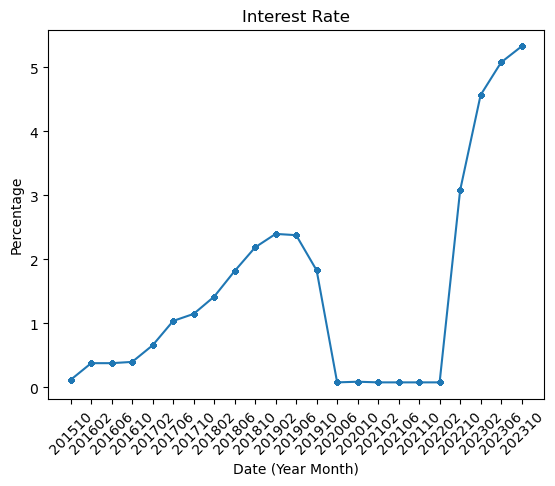

In [16]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["interest_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Interest Rate")

Text(0.5, 1.0, 'Inflation Rate')

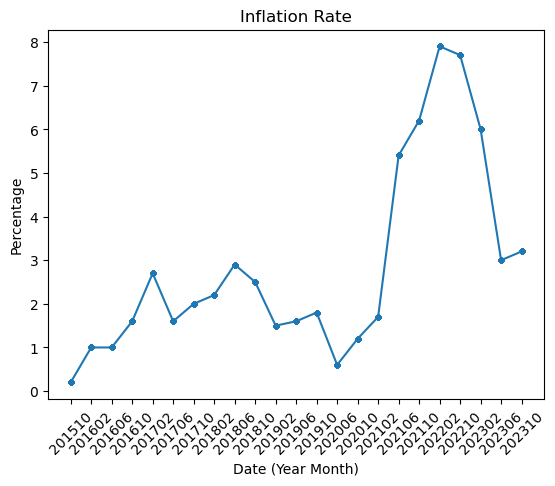

In [17]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["inflat_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Inflation Rate")

In [18]:
groupbydate = df_final_cleaned.groupby("date")["Late90Days"].count()
groupbydate.name = "CntLatePayment"
groupbydate = groupbydate.reset_index()

Text(0.5, 1.0, 'Late Payments Over Time')

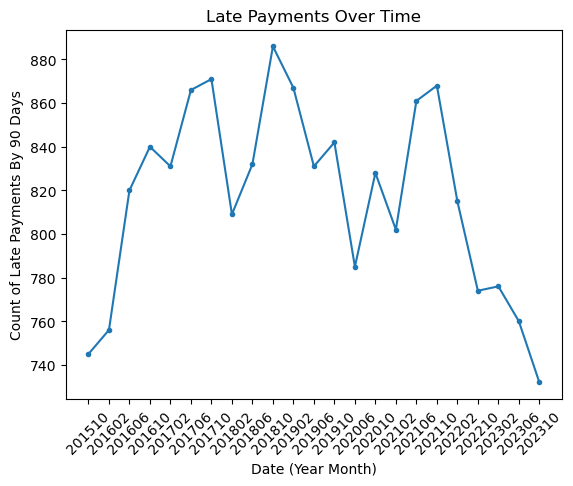

In [19]:
plt.plot(groupbydate["date"], groupbydate["CntLatePayment"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Count of Late Payments By 90 Days")
plt.title("Late Payments Over Time")

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\3377788971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


Text(0, 0.5, 'Frequency')

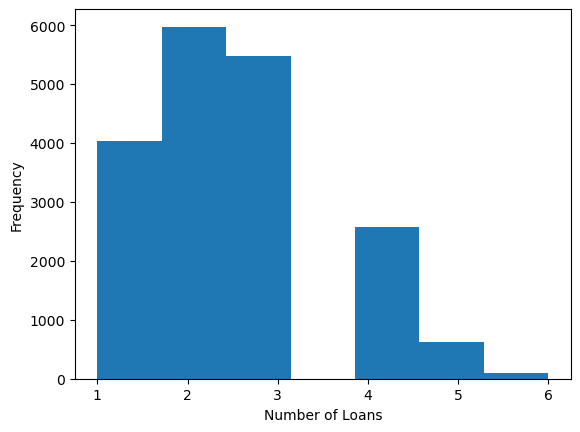

In [20]:
df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

plt.hist(df_final_cleaned["loan_count"], bins = 7)
plt.xlabel("Number of Loans")
plt.ylabel("Frequency")

In [21]:
df_final_cleaned["Late90Days"].value_counts()

Late90Days
0.0    18301
1.0      496
Name: count, dtype: int64

In [22]:
df_final_cleaned["loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\1916653963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


In [23]:
df_final_cleaned["loan_count"].describe()

count    18797.000000
mean         2.473373
std          1.103495
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: loan_count, dtype: float64

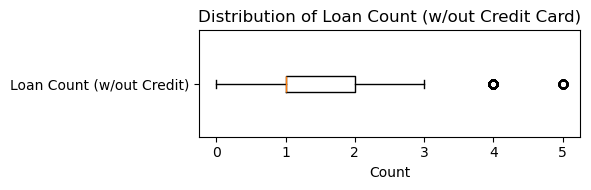

In [24]:
plt.figure(figsize=(6, 2))
plt.boxplot(df_final_cleaned["loan_count(w/outCredit)"], vert=False)
plt.yticks([1], ["Loan Count (w/out Credit)"])
plt.xlabel("Count")
plt.title("Distribution of Loan Count (w/out Credit Card)")
plt.tight_layout()


In [25]:
high_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]>=
                                   df_final_cleaned["loan_count"].quantile(0.8))]
high_num_loans["Late30Days"].value_counts()

Late30Days
0.0    8103
1.0     688
Name: count, dtype: int64

In [26]:
high_num_loans["Late90Days"].value_counts()

Late90Days
0.0    8506
1.0     285
Name: count, dtype: int64

In [27]:
low_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]<=df_final_cleaned["loan_count"].quantile(0.2))]
low_num_loans["Late30Days"].value_counts()

Late30Days
0.0    3929
1.0     104
Name: count, dtype: int64

In [28]:
low_num_loans["Late90Days"].value_counts()

Late90Days
0.0    3983
1.0      50
Name: count, dtype: int64

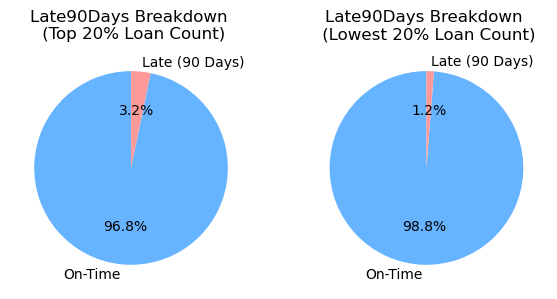

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
high_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Late90Days Breakdown \n (Top 20% Loan Count)")

# Low loan count pie chart
low_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[1]
)
axes[1].set_ylabel("")
axes[1].set_title("Late90Days Breakdown \n (Lowest 20% Loan Count)")

plt.tight_layout()
plt.show()

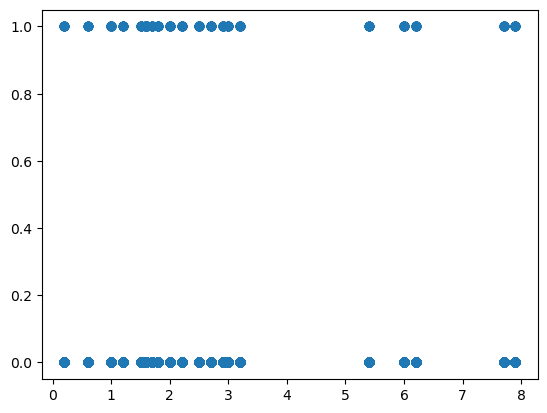

In [30]:
plt.scatter(df_final_cleaned["inflat_rate"], df_final_cleaned["Late90Days"])

In [31]:
table_normalized = pd.crosstab(
    df_final_cleaned["date"],
    df_final_cleaned["Late90Days"],
    normalize='index'  # This gives row-wise (date-wise) percentages
)
table_normalized

Late90Days,0.0,1.0
date,,
201510,0.974497,0.025503
201602,0.970899,0.029101
201606,0.979268,0.020732
201610,0.966667,0.033333
201702,0.971119,0.028881
201706,0.967667,0.032333
201710,0.974742,0.025258
201802,0.970334,0.029666
201806,0.963942,0.036058


C:\Users\izzyd\AppData\Local\Temp\ipykernel_22404\2837294837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] +


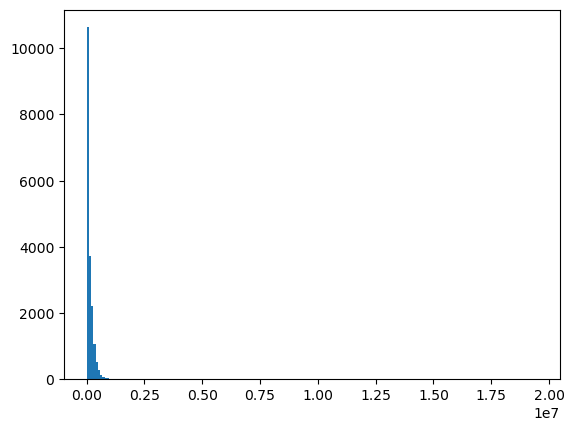

In [32]:
df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] + 
                          df_final_cleaned["HomeBasedBal"] + df_final_cleaned["AutoBal"] + df_final_cleaned["OtherBal"])
plt.hist(df_final_cleaned["TotalBal"], bins = 200);
plt.show()

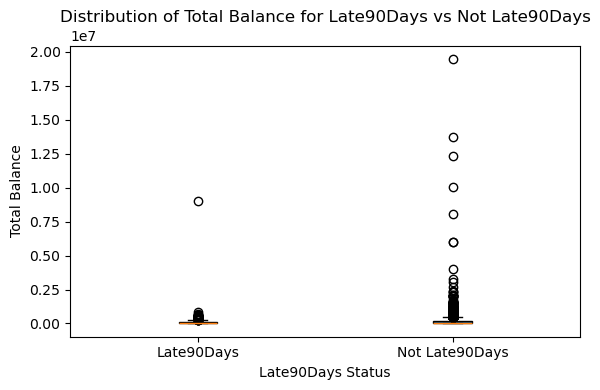

In [33]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([late["TotalBal"], not_late["TotalBal"]], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Late90Days", "Not Late90Days"])

plt.ylabel("Total Balance")
plt.xlabel("Late90Days Status")
plt.title("Distribution of Total Balance for Late90Days vs Not Late90Days")

plt.tight_layout()
plt.show()

c:\Users\izzyd\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


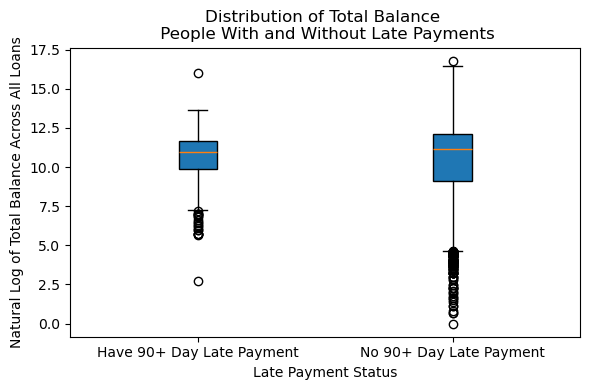

In [34]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([np.log(late["TotalBal"]), np.log(not_late["TotalBal"])], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Have 90+ Day Late Payment", "No 90+ Day Late Payment"])

plt.ylabel("Natural Log of Total Balance Across All Loans")
plt.xlabel("Late Payment Status")
plt.title("Distribution of Total Balance \n People With and Without Late Payments")

plt.tight_layout()
plt.show()

In [35]:
df_final_cleaned[["CreditBal", "MortgageBal", 
                   "StudentBal", "HomeBasedBal", "AutoBal", "OtherBal",
                   "Late30Days", "Late90Days"]].corr()

,CreditBal,MortgageBal,StudentBal,HomeBasedBal,AutoBal,OtherBal,Late30Days,Late90Days
CreditBal,1.000000,0.111665,0.004408,0.019391,0.450523,0.025393,0.016354,0.009682
MortgageBal,0.111665,1.000000,0.064296,0.031566,0.139444,0.003831,-0.035410,-0.024075
StudentBal,0.004408,0.064296,1.000000,-0.004169,0.596848,0.002350,0.021859,0.018978
HomeBasedBal,0.019391,0.031566,-0.004169,1.000000,0.043090,-0.000250,-0.004321,-0.010626
AutoBal,0.450523,0.139444,0.596848,0.043090,1.000000,0.000258,0.017104,0.004353
OtherBal,0.025393,0.003831,0.002350,-0.000250,0.000258,1.000000,0.015415,0.000028
Late30Days,0.016354,-0.035410,0.021859,-0.004321,0.017104,0.015415,1.000000,0.650335
Late90Days,0.009682,-0.024075,0.018978,-0.010626,0.004353,0.000028,0.650335,1.000000


In [36]:
credit_score = pd.get_dummies(df_final_cleaned["CreditScore"], 
                              prefix="CreditScore", 
                              drop_first=True)
last_checked = pd.get_dummies(df_final_cleaned["LastCheckCredit"], 
                              prefix="LastCheckCredit",
                              drop_first=True)
X_merged = pd.concat([df_final_cleaned, credit_score, last_checked], axis =1)
X_merged.columns

Index(['userid', 'date', 'weight', 'HaveCredit', 'HaveMortgage', 'HaveStudent',
       'HaveHomeBasedLoan', 'HaveAuto', 'Other', 'CreditBal', 'MortgageBal',
       'StudentBal', 'HomeBasedBal', 'AutoBal', 'OtherBal', 'MaxedCredit',
       'Late30Days', 'Late90Days', 'CreditScore', 'LastCheckCredit',
       'LikAble2k', 'year', 'inflat_rate', 'interest_rate', 'gdp', 'gdp_cap',
       'loan_count', 'loan_count(w/outCredit)', 'TotalBal', 'CreditScore_2.0',
       'CreditScore_3.0', 'CreditScore_4.0', 'CreditScore_5.0',
       'CreditScore_6.0', 'LastCheckCredit_2.0', 'LastCheckCredit_3.0',
       'LastCheckCredit_4.0', 'LastCheckCredit_5.0', 'LastCheckCredit_6.0'],
      dtype='object')

In [ ]:
X = sm.add_constant(df_final_cleaned.drop(columns=["Late90Days","CreditScore",
                                                   "LastCheckCredit","date","year",
                                                   "weight", "userid","HaveCredit",'HaveMortgage', 
                                                   'HaveStudent','HaveHomeBasedLoan', 
                                                   'CreditBal', 'HomeBasedBal', 
                                                   'AutoBal', 'OtherBal',
                                                   'HaveAuto', 'Other',
                                                   "loan_count(w/outCredit)"]))
y = df_final_cleaned["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

logistic = sm.Logit(y_train, X_train).fit()
logistic.summary()

         Current function value: 0.039579
         Iterations: 35


c:\Users\izzyd\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Late90Days   No. Observations:                13157
Model:                          Logit   Df Residuals:                    13145
Method:                           MLE   Df Model:                           11
Date:                Wed, 30 Apr 2025   Pseudo R-squ.:                  0.6753
Time:                        11:39:05   Log-Likelihood:                -520.74
converged:                      False   LL-Null:                       -1603.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -98.5639   3.77e+04     -0.003      0.998   -7.39e+04    7.37e+04
MortgageBal    5.744e-07   1.05e-06      0.548      0.583   -1.48e-06    2.63e-06
StudentBal     5.793e-06    2.2e-06      2.629      0.009    1.47e-06    1.01e-05
MaxedCredit      -0.0528      0.159     -0.332      0.740      -0.364       0.259
Late30Days       97.4224   3.77e+04      0.003      0.998   -7.37e+04    7.39e+04
LikAble2k        -0.0096      0.002     -4.161      0.000      -0.014      -0.005
inflat_rate       0.1226      0.061      2.007      0.045       0.003       0.242
interest_rate     0.0525      0.085      0.620      0.535      -0.113       0.218
gdp            -1.29e-12   1.21e-12     -1.065      0.287   -3.66e-12    1.08e-12
gdp_cap           0.0004      0.000      0.987      0.324      -0.000       0.001
loan_count       -0.1844      0.074     -2.502      0.012      -0.329      -0.040
TotalBal        -5.5e-07   9.14e-07     -0.602      0.547   -2.34e-06    1.24e-06
=================================================================================

Possibly complete quasi-separation: A fraction 0.94 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
X_test = sm.add_constant(X_test)
predictions_test = (logistic.predict(X_test) >= 0.5).astype(int)

In [ ]:
confusion_matrix(y_test, predictions_test)

array([[5420,   71],
       [  87,   62]])

In [ ]:
print(precision_score(y_test, predictions_test))
print (recall_score(y_test, predictions_test))

0.46616541353383456
0.4161073825503356


# Israel Test Part

In [37]:
X_merged['Late90Days'] = pd.Categorical(df_final_cleaned['Late90Days'], categories=[0, 1], ordered=False).rename_categories({0: 'not late', 1: 'late'})

X_merged

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,CreditScore_2.0,CreditScore_3.0,CreditScore_4.0,CreditScore_5.0,CreditScore_6.0,LastCheckCredit_2.0,LastCheckCredit_3.0,LastCheckCredit_4.0,LastCheckCredit_5.0,LastCheckCredit_6.0
7004,70051996,201510,1.048000,1,0,0,0,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7005,70052003,201510,0.491000,1,1,1,0,1,0,2000.0,...,False,False,False,True,False,False,False,True,False,False
7006,70052014,201510,0.577000,1,0,0,1,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7008,70052043,201510,1.087000,1,0,1,0,1,0,311.0,...,False,False,False,False,False,False,True,False,False,False
7010,70052292,201510,0.784000,1,1,0,0,0,0,1500.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,75015207,202310,0.949974,1,0,0,0,0,1,3000.0,...,False,False,False,True,False,False,False,False,False,False
33376,75015209,202310,0.462812,1,1,1,1,1,0,5000.0,...,False,False,False,True,False,True,False,False,False,False
33377,75015213,202310,0.936813,1,1,0,0,1,0,1000.0,...,False,False,False,True,False,True,False,False,False,False
33379,75015225,202310,1.370018,1,0,0,0,1,0,3000.0,...,True,False,False,False,False,False,True,False,False,False


In [38]:
X = X_merged.drop(columns=["Late90Days","Late30Days","userid","date","weight","HaveCredit",
                                   'HaveMortgage',"loan_count(w/outCredit)","LastCheckCredit","year"])



Y = X_merged["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)
# Store the original column names before scaling
feature_names = X.columns.tolist()
#used to downsample outcomes as we have a 97% to 3%split
rus = RandomUnderSampler(random_state=42)
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)
#will be used for folds
cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)


c:\Users\izzyd\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\izzyd\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [39]:

scaler=StandardScaler()

X_train_scaled_down=scaler.fit_transform(X_train_down)
X_test_scaled=scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to preserve column names
X_train_scaled_down = pd.DataFrame(X_train_scaled_down, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [40]:
# Grid search for regularization with resampled data
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both L1 and L2
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=['accuracy',"roc_auc"],
    n_jobs=-1,
    verbose=1,
    refit="roc_auc"
)

# Use your resampled data here
grid_search.fit(X_train_scaled_down, y_train_down)
log_down = grid_search.best_estimator_
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC: 0.933465958532121



Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.050681
23      CreditScore_6.0    0.027163
19      CreditScore_2.0    0.010557
20      CreditScore_3.0    0.006241
2              HaveAuto    0.001163
14        interest_rate    0.000000
1     HaveHomeBasedLoan    0.000000
27  LastCheckCredit_5.0    0.000000
26  LastCheckCredit_4.0    0.000000
22      CreditScore_5.0    0.000000
18             TotalBal    0.000000
17           loan_count    0.000000
16              gdp_cap    0.000000
15                  gdp    0.000000
28  LastCheckCredit_6.0    0.000000
13          inflat_rate    0.000000
9              OtherBal    0.000000
8               AutoBal    0.000000
7          HomeBasedBal    0.000000
6            StudentBal    0.000000
5           MortgageBal    0.000000
4             CreditBal    0.000000
24  LastCheckCredit_2.0   -0.000248
3                 Other   -0.000252
25  LastCheckCredit_3.0   -0.000333
0           HaveStudent   -0.0018

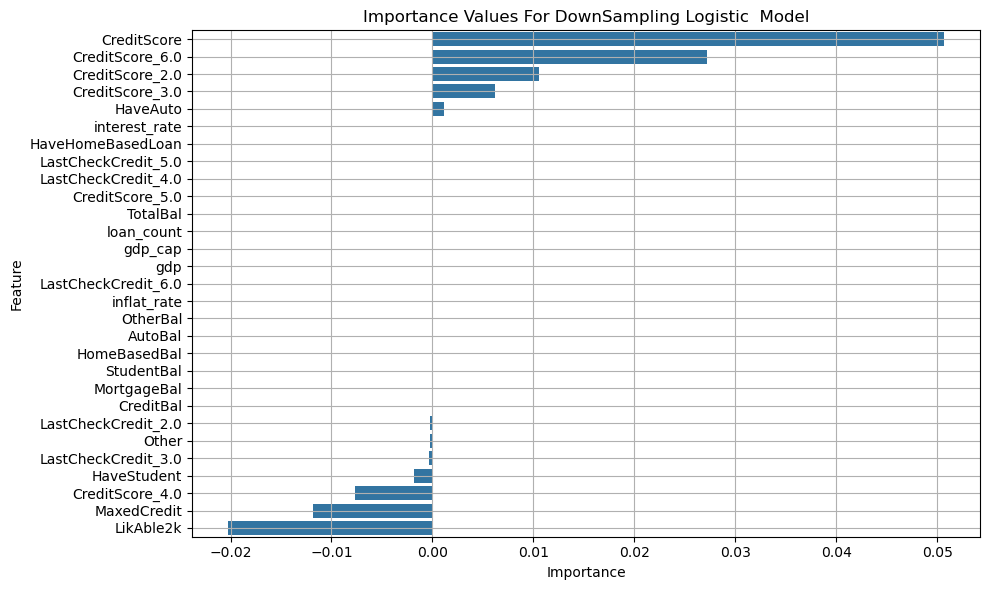

In [41]:

# Make sure your model is already fitted
result = permutation_importance(log_down, X_test_scaled, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")
# Build DataFrame
log_feature_down = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(log_feature_down)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=log_feature_down)
plt.title('Importance Values For DownSampling Logistic  Model')
plt.tight_layout()
plt.grid(True)

In [42]:
y_pred= log_down.predict(X_test_scaled)

In [43]:
# Calculate metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        late       0.14      0.90      0.24       149
    not late       1.00      0.85      0.92      5491

    accuracy                           0.85      5640
   macro avg       0.57      0.88      0.58      5640
weighted avg       0.97      0.85      0.90      5640



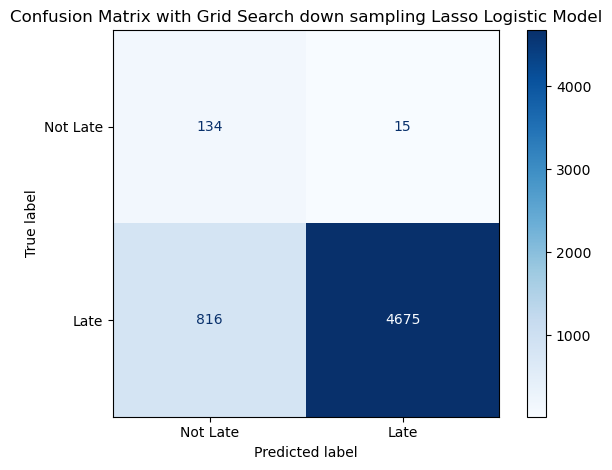

In [44]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search down sampling Lasso Logistic Model')
plt.tight_layout()

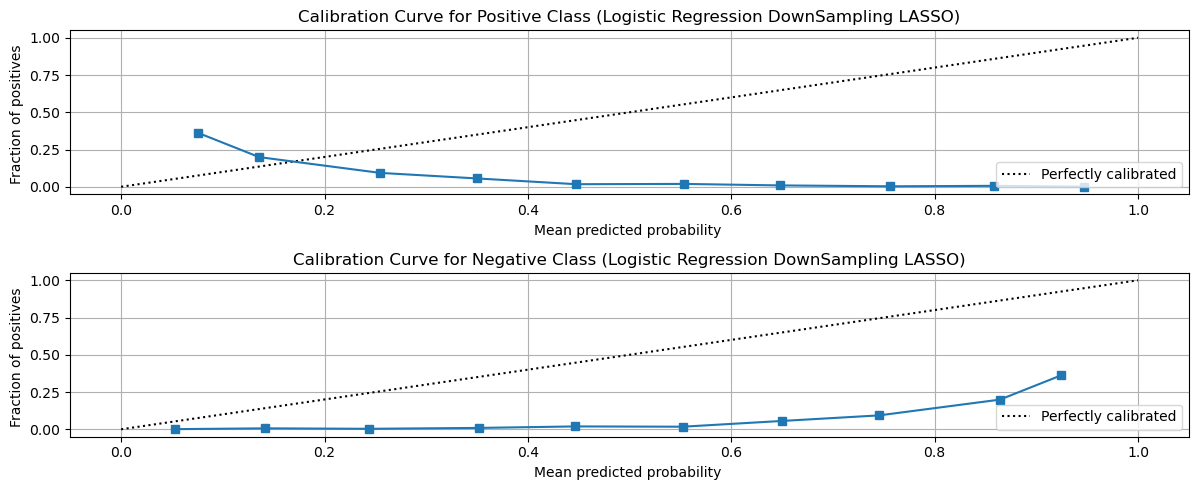

In [45]:

# Convert labels
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

# Predict probabilities
y_pred_proba_pos = log_down.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_neg = log_down.predict_proba(X_test_scaled)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve for Positive Class (Logistic Regression DownSampling LASSO)")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve for Negative Class (Logistic Regression DownSampling LASSO)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Logistic With UpSampling

In [46]:
ros = RandomOverSampler(random_state=42)
X_train_up, y_train_up = ros.fit_resample(X_train, y_train)

scaler=StandardScaler()

X_train_scaled_up=scaler.fit_transform(X_train_up)
X_test_scaled=scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to preserve column names
X_train_scaled_up = pd.DataFrame(X_train_scaled_up, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)


c:\Users\izzyd\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\izzyd\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [47]:
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=['accuracy',"roc_auc"],
    n_jobs=-1,
    verbose=1,
    refit="roc_auc"
)

# Use your resampled data here
grid_search.fit(X_train_scaled_up, y_train_up)
log_up = grid_search.best_estimator_
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC: 0.9497288022079745


In [48]:
y_pred= log_up.predict(X_test_scaled)
# Calculate metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        late       0.16      0.86      0.27       149
    not late       1.00      0.88      0.93      5491

    accuracy                           0.88      5640
   macro avg       0.58      0.87      0.60      5640
weighted avg       0.97      0.88      0.92      5640



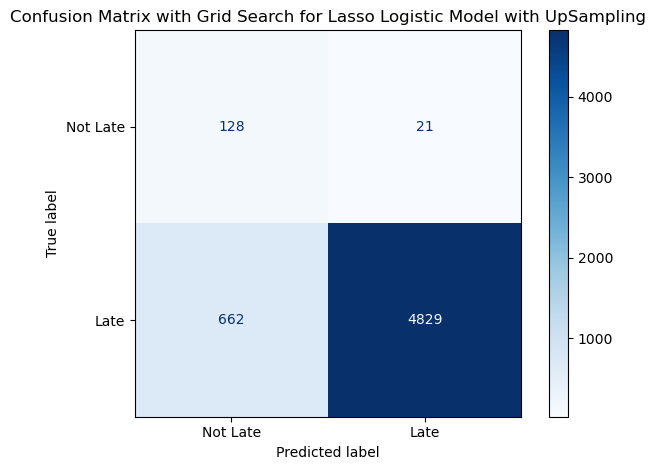

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Lasso Logistic Model with UpSampling')
plt.tight_layout()

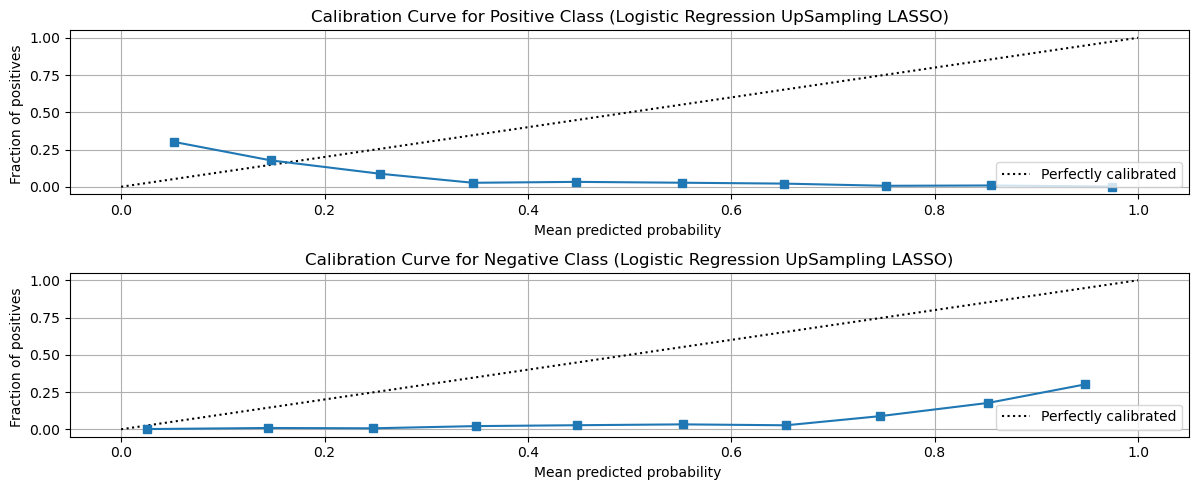

In [51]:

# Convert labels
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

# Predict probabilities
y_pred_proba_pos = log_up.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_neg = log_up.predict_proba(X_test_scaled)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve for Positive Class (Logistic Regression UpSampling LASSO)")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve for Negative Class (Logistic Regression UpSampling LASSO)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.053794
23      CreditScore_6.0    0.025819
19      CreditScore_2.0    0.024344
20      CreditScore_3.0    0.006645
13          inflat_rate    0.006379
2              HaveAuto    0.004230
16              gdp_cap    0.003309
14        interest_rate    0.003156
5           MortgageBal    0.002411
6            StudentBal    0.001695
24  LastCheckCredit_2.0    0.000642
25  LastCheckCredit_3.0    0.000284
7          HomeBasedBal    0.000216
26  LastCheckCredit_4.0    0.000206
28  LastCheckCredit_6.0    0.000071
15                  gdp    0.000000
18             TotalBal    0.000000
22      CreditScore_5.0    0.000000
9              OtherBal    0.000000
4             CreditBal    0.000000
8               AutoBal   -0.000014
1     HaveHomeBasedLoan   -0.000046
17           loan_count   -0.000642
27  LastCheckCredit_5.0   -0.000656
3                 Other   -0.000918
21      CreditScore_4.0   -0.0032

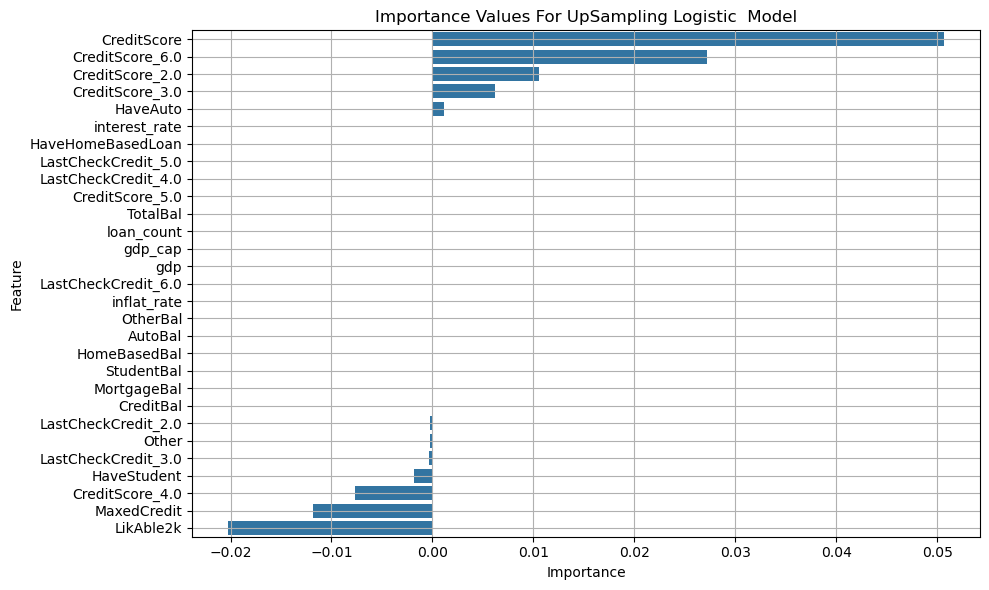

In [52]:
# Make sure your model is already fitted
result = permutation_importance(log_up, X_test_scaled, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")
# Build DataFrame
log_feature_up = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(log_feature_up)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=log_feature_down)
plt.title('Importance Values For UpSampling Logistic  Model')
plt.tight_layout()
plt.grid(True)

## Random Forest
### Up Sampling

In [53]:
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rf_param_grid, cv=cv,
                        scoring=['accuracy',"roc_auc"], 
                        n_jobs=-1, 
                        verbose=3,
                        refit="roc_auc")
rf_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 300, 500]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=3)

In [55]:
print(f" Best Score is:", rf_grid.best_score_)
print(f"Best Parameter are :",rf_grid.best_estimator_)
rand_up=rf_grid.best_estimator_

 Best Score is: 1.0
Best Parameter are : RandomForestClassifier(max_features=None, random_state=42)


In [56]:
rand_pred_up= rand_up.predict(X_test)
print(classification_report(y_test, rand_pred_up))

              precision    recall  f1-score   support

        late       0.31      0.23      0.26       149
    not late       0.98      0.99      0.98      5491

    accuracy                           0.97      5640
   macro avg       0.64      0.61      0.62      5640
weighted avg       0.96      0.97      0.96      5640



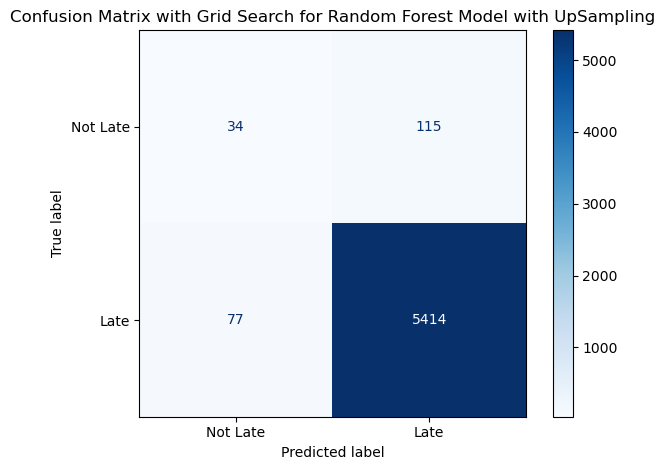

In [57]:
conf_matrix = confusion_matrix(y_test, rand_pred_up)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Random Forest Model with UpSampling')
plt.tight_layout()

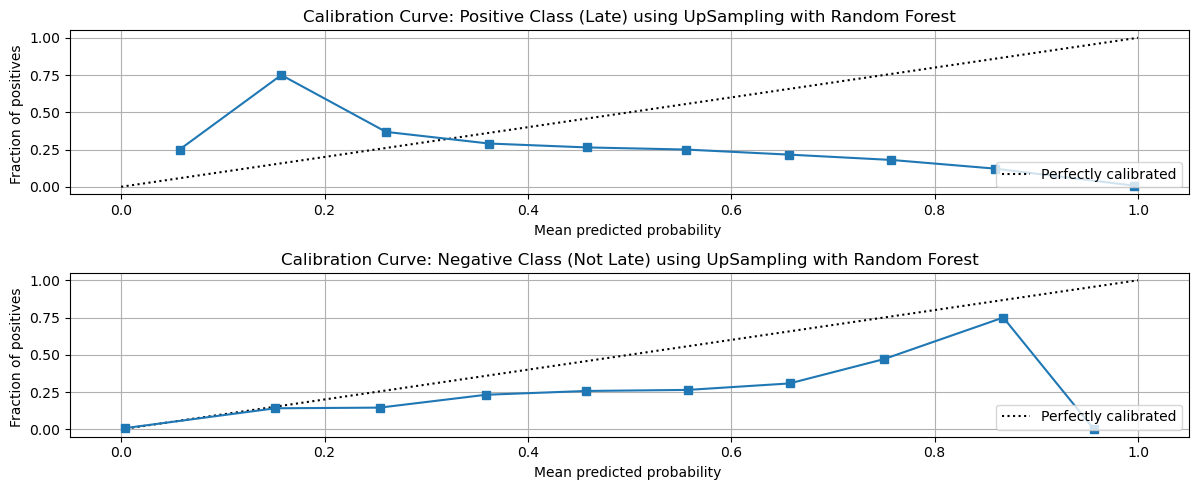

In [58]:
# Convert labels
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

# Predict probabilities
y_pred_proba_pos = rand_up.predict_proba(X_test)[:, 1]
y_pred_proba_neg = rand_up.predict_proba(X_test)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using UpSampling with Random Forest")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using UpSampling with Random Forest")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.539088
12            LikAble2k    0.098545
4             CreditBal    0.047734
18             TotalBal    0.041465
6            StudentBal    0.037922
19      CreditScore_2.0    0.029505
13          inflat_rate    0.024768
14        interest_rate    0.023892
8               AutoBal    0.021597
5           MortgageBal    0.017806
10          MaxedCredit    0.016338
23      CreditScore_6.0    0.015767
9              OtherBal    0.011543
17           loan_count    0.010109
24  LastCheckCredit_2.0    0.008663
16              gdp_cap    0.008326
15                  gdp    0.007798
26  LastCheckCredit_4.0    0.006395
27  LastCheckCredit_5.0    0.005546
20      CreditScore_3.0    0.005409
28  LastCheckCredit_6.0    0.004814
25  LastCheckCredit_3.0    0.004381
7          HomeBasedBal    0.003814
3                 Other    0.002222
0           HaveStudent    0.002112
2              HaveAuto    0.0019

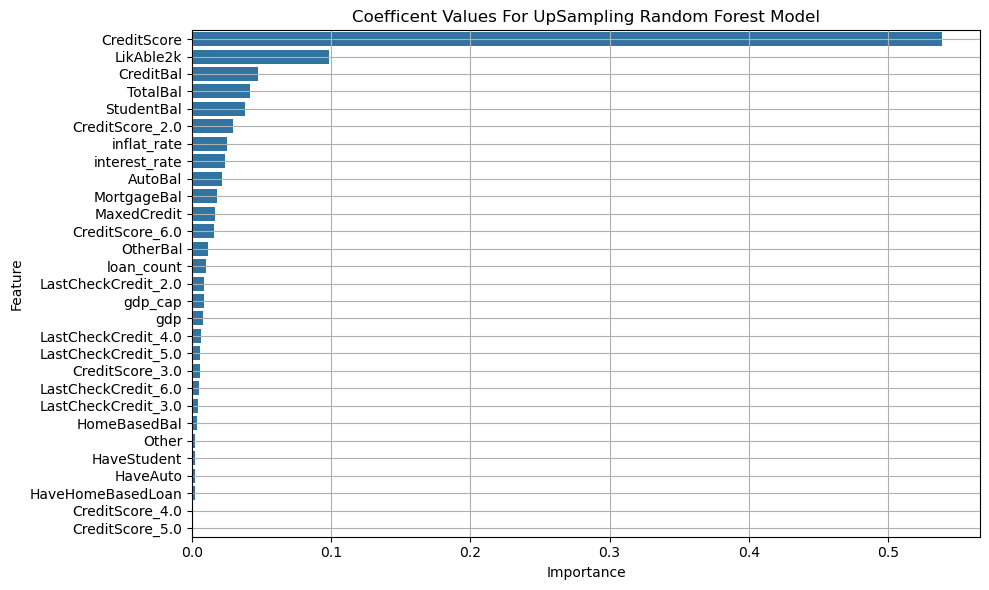

In [59]:

print("\nFeature Coeffiecent Analysis:")
rand_up_import = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rand_up.feature_importances_
}).sort_values('Importance', ascending=False)
print(rand_up_import)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rand_up_import)
plt.title('Coefficent Values For UpSampling Random Forest Model')
plt.tight_layout()
plt.grid(True)


### Down Sampling

In [60]:
rf_grid.fit(X_train_down,y_train_down)
print(f" Best Score is:", rf_grid.best_score_)
print(f"Best Parameter are :",rf_grid.best_estimator_)
rand_down=rf_grid.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
 Best Score is: 0.9231511987277583
Best Parameter are : RandomForestClassifier(max_depth=10, max_features=None, n_estimators=300,
                       random_state=42)


              precision    recall  f1-score   support

        late       0.15      0.84      0.26       149
    not late       1.00      0.87      0.93      5491

    accuracy                           0.87      5640
   macro avg       0.57      0.86      0.59      5640
weighted avg       0.97      0.87      0.91      5640



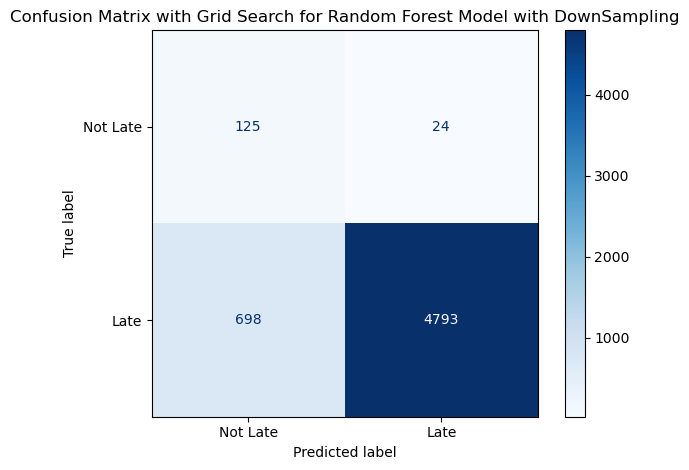

In [61]:
rand_pred_down= rand_down.predict(X_test)
print(classification_report(y_test, rand_pred_down))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,rand_pred_down),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Random Forest Model with DownSampling')
plt.tight_layout()

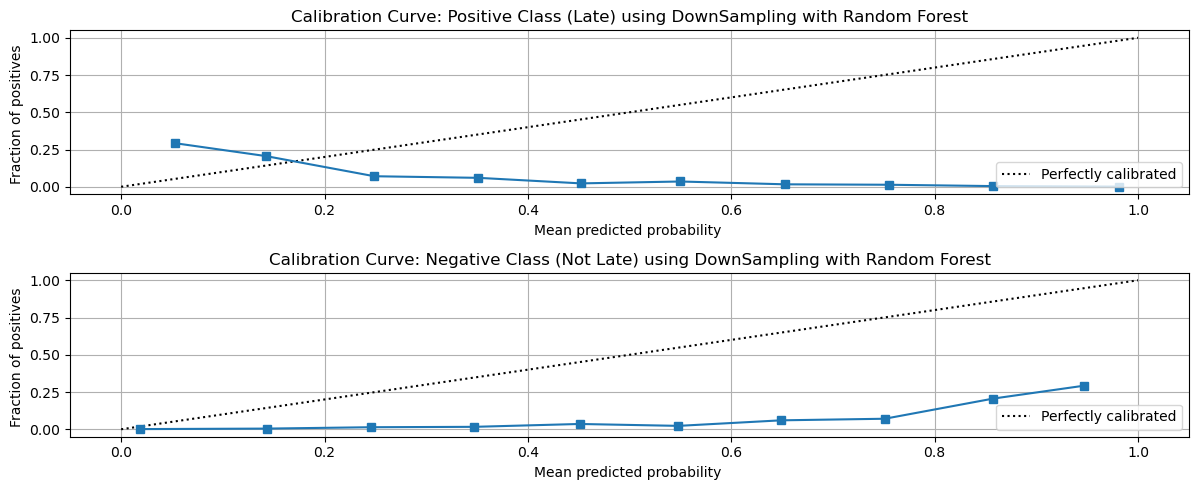

In [62]:
# Predict probabilities
y_pred_proba_pos = rand_down.predict_proba(X_test)[:, 1]
y_pred_proba_neg = rand_down.predict_proba(X_test)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using DownSampling with Random Forest")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using DownSampling with Random Forest")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.539088
12            LikAble2k    0.098545
4             CreditBal    0.047734
18             TotalBal    0.041465
6            StudentBal    0.037922
19      CreditScore_2.0    0.029505
13          inflat_rate    0.024768
14        interest_rate    0.023892
8               AutoBal    0.021597
5           MortgageBal    0.017806
10          MaxedCredit    0.016338
23      CreditScore_6.0    0.015767
9              OtherBal    0.011543
17           loan_count    0.010109
24  LastCheckCredit_2.0    0.008663
16              gdp_cap    0.008326
15                  gdp    0.007798
26  LastCheckCredit_4.0    0.006395
27  LastCheckCredit_5.0    0.005546
20      CreditScore_3.0    0.005409
28  LastCheckCredit_6.0    0.004814
25  LastCheckCredit_3.0    0.004381
7          HomeBasedBal    0.003814
3                 Other    0.002222
0           HaveStudent    0.002112
2              HaveAuto    0.0019

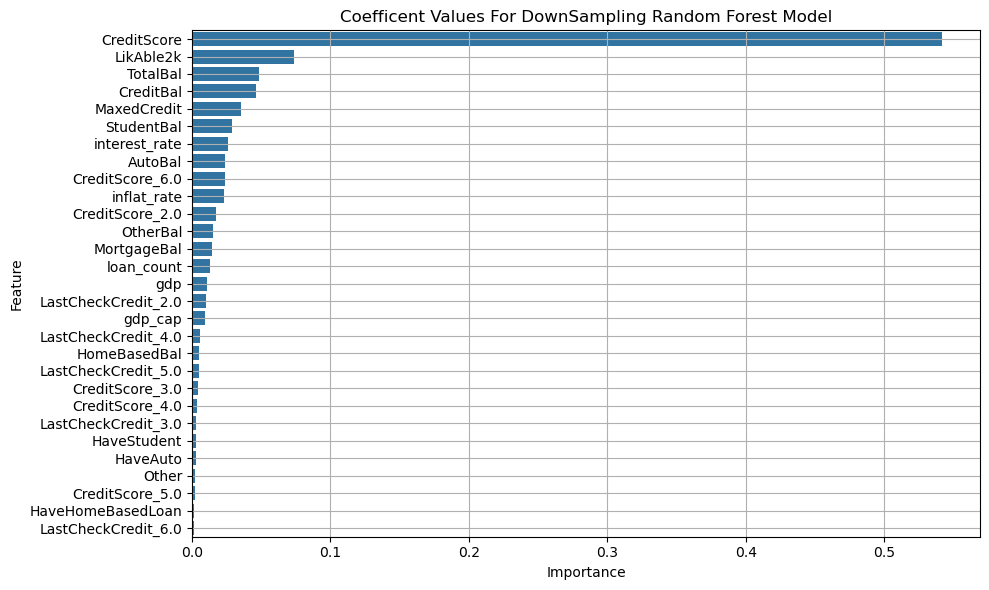

In [63]:
print("\nFeature Coeffiecent Analysis:")
rand_down_import = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rand_down.feature_importances_
}).sort_values('Importance', ascending=False)
print(rand_up_import)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rand_down_import)
plt.title('Coefficent Values For DownSampling Random Forest Model')
plt.tight_layout()
plt.grid(True)

## HistGradientBoostingClassifier
### UpSampling

In [64]:
hgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_iter': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'l2_regularization': [0.0, 0.1, 1.0, 10.0]
}

hgb_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=42), 
                        hgb_param_grid, 
                        cv=cv, 
                        scoring=["roc_auc",'accuracy'], 
                        n_jobs=-1, 
                        verbose=3,
                        refit="roc_auc")


In [65]:
hgb_grid.fit(X_train_up, y_train_up)
print(f" Best Score is:", hgb_grid.best_score_)
print(f"Best Parameter are :",hgb_grid.best_estimator_)
hgb_up=hgb_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
 Best Score is: 0.9998892417309125
Best Parameter are : HistGradientBoostingClassifier(max_depth=10, max_iter=500, random_state=42)


              precision    recall  f1-score   support

        late       0.38      0.40      0.39       149
    not late       0.98      0.98      0.98      5491

    accuracy                           0.97      5640
   macro avg       0.68      0.69      0.69      5640
weighted avg       0.97      0.97      0.97      5640



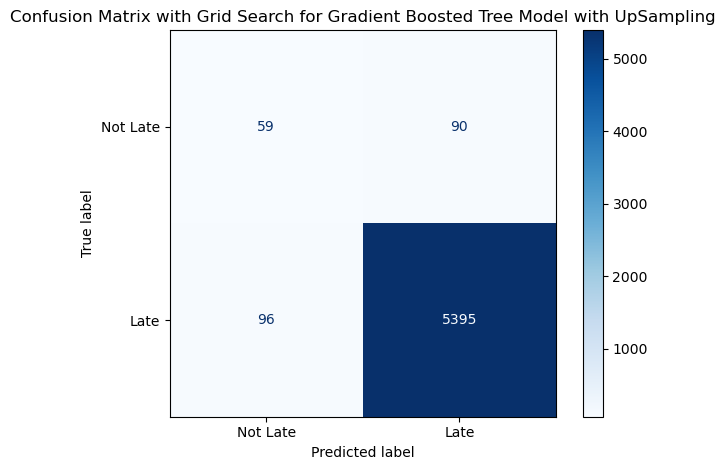

In [66]:
hgb_pred_up= hgb_up.predict(X_test)
print(classification_report(y_test, hgb_pred_up))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,hgb_pred_up),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Gradient Boosted Tree Model with UpSampling')
plt.tight_layout()

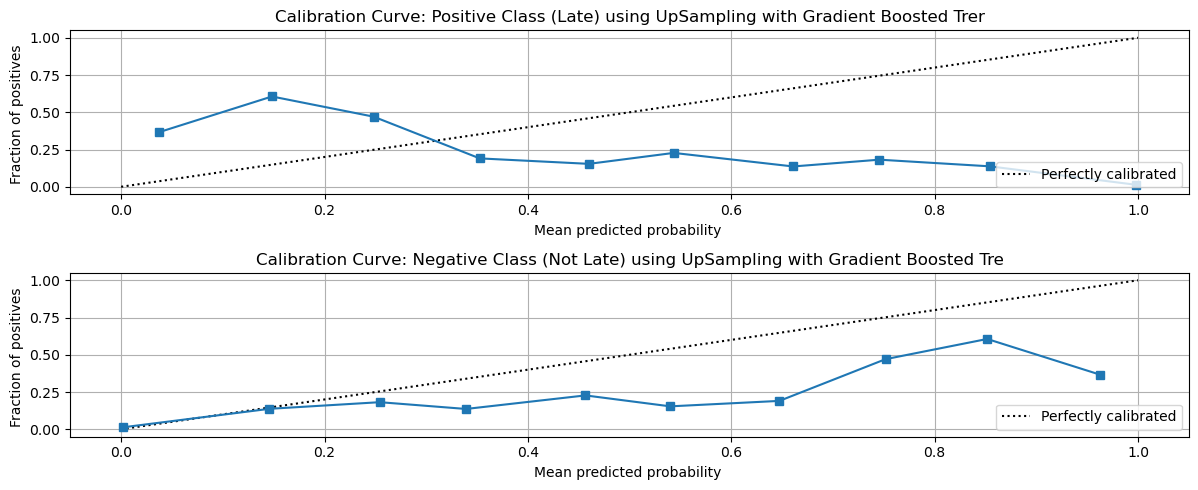

In [67]:
# Predict probabilities
y_pred_proba_pos = hgb_up.predict_proba(X_test)[:, 1]
y_pred_proba_neg = hgb_up.predict_proba(X_test)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using UpSampling with Gradient Boosted Trer")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using UpSampling with Gradient Boosted Tre")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Importance Analysis:
                Feature  Importance
18             TotalBal    0.003163
8               AutoBal    0.002826
5           MortgageBal    0.000433
25  LastCheckCredit_3.0    0.000344
24  LastCheckCredit_2.0    0.000301
7          HomeBasedBal    0.000099
1     HaveHomeBasedLoan    0.000050
3                 Other    0.000007
16              gdp_cap    0.000000
26  LastCheckCredit_4.0   -0.000067
28  LastCheckCredit_6.0   -0.000184
20      CreditScore_3.0   -0.000191
27  LastCheckCredit_5.0   -0.000280
0           HaveStudent   -0.000298
2              HaveAuto   -0.000333
19      CreditScore_2.0   -0.000351
17           loan_count   -0.000404
10          MaxedCredit   -0.000500
9              OtherBal   -0.000539
15                  gdp   -0.000628
23      CreditScore_6.0   -0.000649
21      CreditScore_4.0   -0.001089
11          CreditScore   -0.001227
13          inflat_rate   -0.001259
6            StudentBal   -0.001294
14        interest_rate   -0.00156

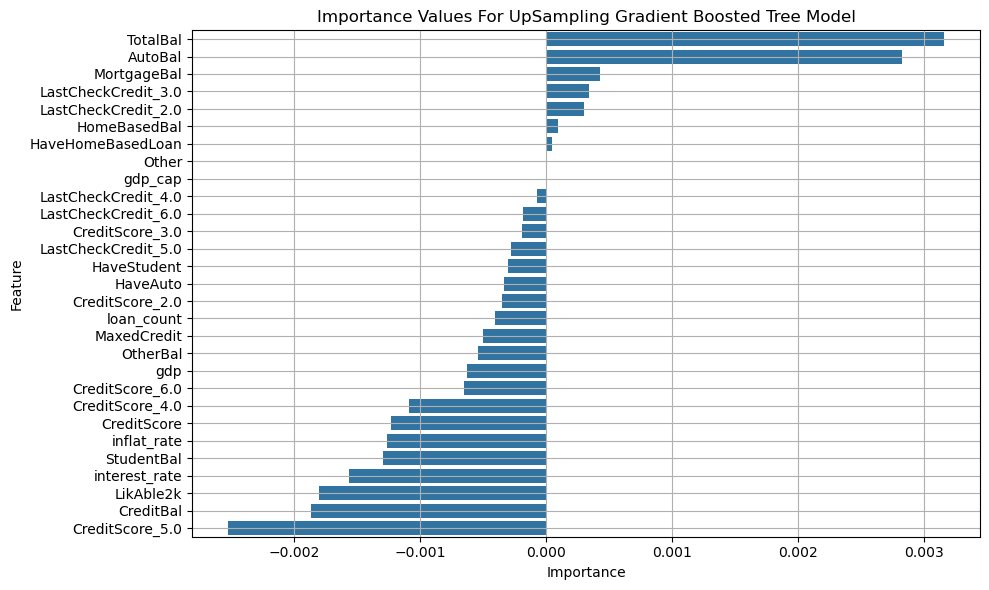

In [68]:
# Make sure your model is already fitted
result = permutation_importance(hgb_up, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Importance Analysis:")
# Build DataFrame
hgbup_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(hgbup_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=hgbup_df)
plt.title('Importance Values For UpSampling Gradient Boosted Tree Model')
plt.tight_layout()
plt.grid(True)

### DownSampling

In [69]:
hgb_grid.fit(X_train_down, y_train_down)
print(f" Best Score is:", hgb_grid.best_score_)
print(f"Best Parameter are :",hgb_grid.best_estimator_)
hbg_down=hgb_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
 Best Score is: 0.9287355597563538
Best Parameter are : HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.01,
                               random_state=42)


              precision    recall  f1-score   support

        late       0.16      0.85      0.26       149
    not late       1.00      0.88      0.93      5491

    accuracy                           0.87      5640
   macro avg       0.58      0.86      0.60      5640
weighted avg       0.97      0.87      0.91      5640



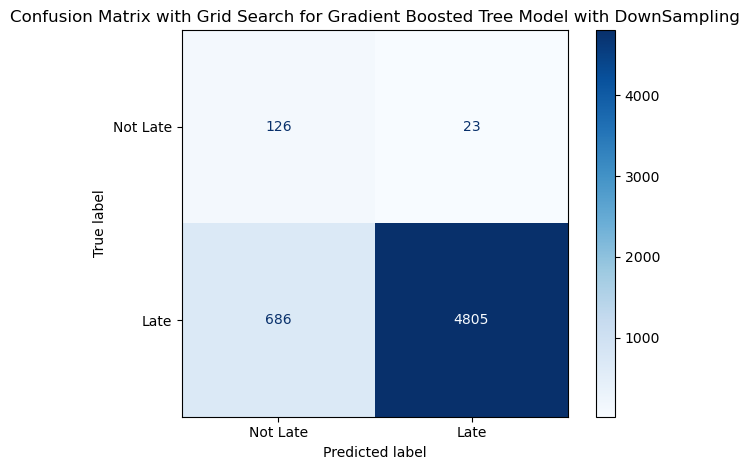

In [70]:
hgb_pred_down= hbg_down.predict(X_test)
print(classification_report(y_test, hgb_pred_down))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,hgb_pred_down),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Gradient Boosted Tree Model with DownSampling')
plt.tight_layout()

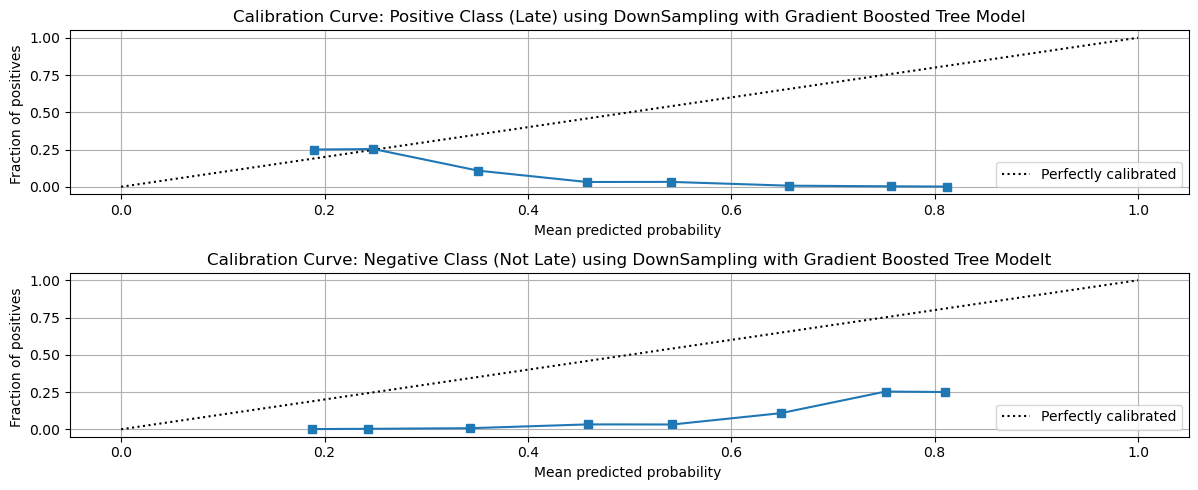

In [71]:
# Predict probabilities
y_pred_proba_pos = hbg_down.predict_proba(X_test)[:, 1]
y_pred_proba_neg = hbg_down.predict_proba(X_test)[:, 0]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using DownSampling with Gradient Boosted Tree Model")
axes[0].grid(True)



# Negative class calibration (optional — less common)
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using DownSampling with Gradient Boosted Tree Modelt")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.006770
8               AutoBal    0.000067
28  LastCheckCredit_6.0    0.000000
13          inflat_rate    0.000000
22      CreditScore_5.0    0.000000
21      CreditScore_4.0    0.000000
25  LastCheckCredit_3.0    0.000000
19      CreditScore_2.0    0.000000
17           loan_count    0.000000
16              gdp_cap    0.000000
15                  gdp    0.000000
1     HaveHomeBasedLoan    0.000000
26  LastCheckCredit_4.0    0.000000
24  LastCheckCredit_2.0    0.000000
9              OtherBal    0.000000
7          HomeBasedBal    0.000000
6            StudentBal    0.000000
5           MortgageBal    0.000000
27  LastCheckCredit_5.0    0.000000
3                 Other    0.000000
2              HaveAuto    0.000000
23      CreditScore_6.0    0.000000
18             TotalBal   -0.000142
10          MaxedCredit   -0.001014
14        interest_rate   -0.001872
20      CreditScore_3.0   -0.0047

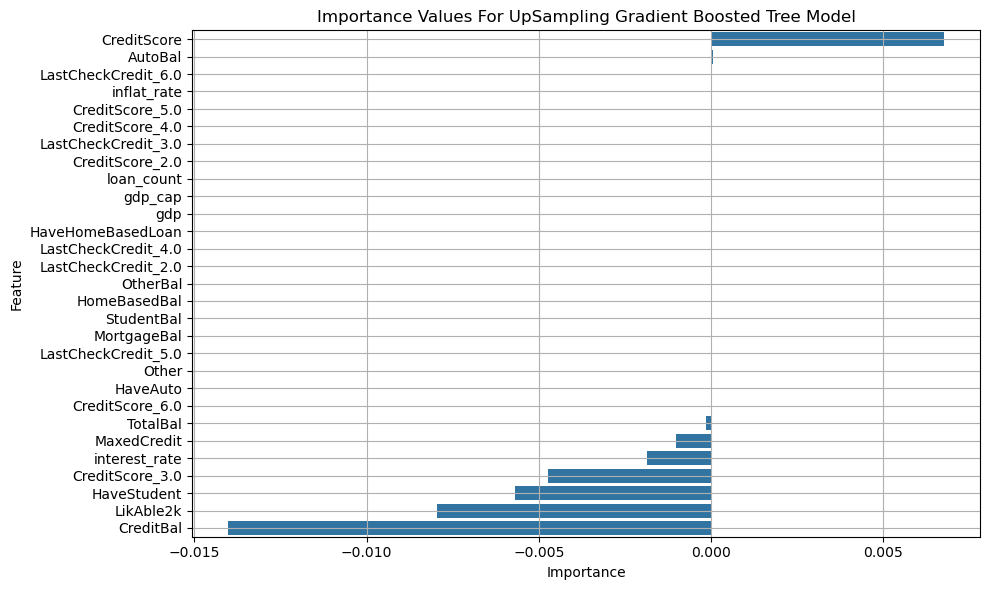

In [72]:
# Make sure your model is already fitted
result = permutation_importance(hbg_down, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")
# Build DataFrame
hgbdown_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(hgbdown_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=hgbdown_df)
plt.title('Importance Values For UpSampling Gradient Boosted Tree Model')
plt.tight_layout()
plt.grid(True)